In [1]:
import numpy as np
import matplotlib.pyplot as plt
import minimint

# Introduction

Here we want to fit an isochrone to the data, using the fact that we expect the distribution to have a main gaussian component perpendicular to the main sequence and a cut off further. To automate this we will need to consider:
1. How we define the cut off of the main sequence.
2. Are the parameters fine tuned enough, we need to look at the code and documentation of the files we use.

For the moment we will begin with knowing the age and the metalicity with the goal of gaining the full averaged line of sight reddening.

# My algorithm ddoesnt account for double counting at the moment.

In [2]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3']

In [3]:
ii = minimint.Interpolator(filters)

# MIST Isochrones

We use the Mist Isochrones here. For now we will have to think of how to get rid of post main sequence stuff

(20.0, -5.0)

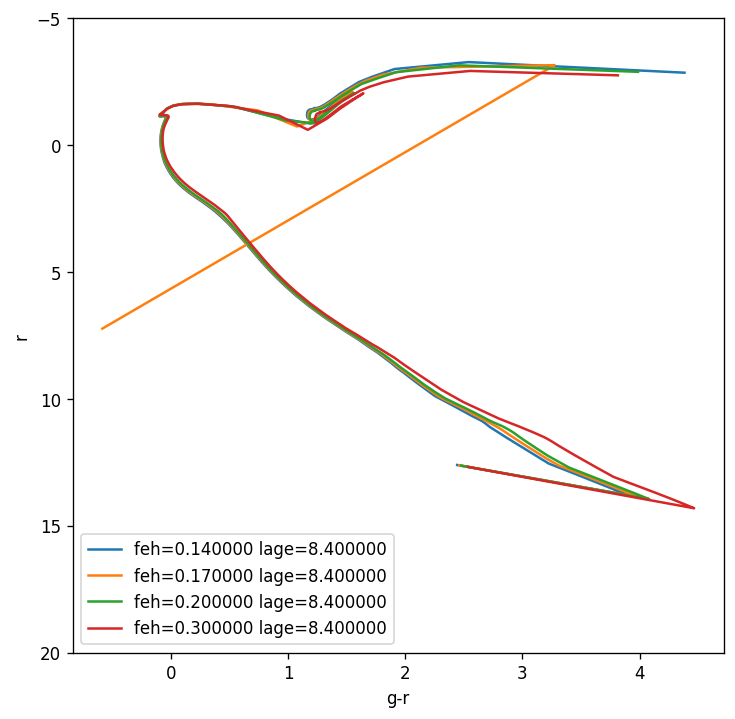

In [4]:
# Compute the isochrones
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 10000)
logagegrid = [8.4]
fehgrid = [0.14,0.17,0.2,0.3]
fig = plt.figure(figsize=(7, 7), dpi=120)
for feh in fehgrid:
    for lage in logagegrid:
        iso = ii(massgrid, lage, feh)
        plt.plot(iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'], iso['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

In [5]:
import os
import pandas as pd
import seaborn as sn

# Import Cluster

Here we look at the high probability elements from our cluster, then we will remove some obvious outliers and set all elements to a commond distance.

In [6]:
os.chdir("../cluster_files")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../Outlier_detection")

#total probability from before.
probability='p3'
cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
scatter=cluster_df[cluster_df[probability]>0.9]
orig_scatter=cluster_df[cluster_df[probability]>0.9]


/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Make common distance

# Cuts made

We make certain cuts here but they definitely have an effect on everything. We will leave in the distance cuts for now.

### It should be noted that the rgeo was used as the estimate for the distance and does produce something off literature for the cluster.

In [7]:
scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
#scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

orig_scatter=scatter

scatter['rgeo']=scatter['rgeo'].median()
orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
#set the main distance.
scatter['rgeo']=2.0
orig_scatter['rgeo']=2.0
def mean_basolute_mag_g_band(selection_gaia):
    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo']*1000)+5   #parsec
    return selection_gaia
mean_basolute_mag_g_band(scatter)
mean_basolute_mag_g_band(orig_scatter)

#cut main sequence
scatter=scatter[scatter.mean_absolute_mag_g_band>0.0].reset_index(drop=True)
# DO I NEED TO DO THE SAME FOR ORIG SCATT
scatter=scatter.sort_values(by=['mean_absolute_mag_g_band'])
orig_scatter=orig_scatter.sort_values(by=['mean_absolute_mag_g_band'])

### Overlay our cluster points with a few different isochrones

(20.0, -5.0)

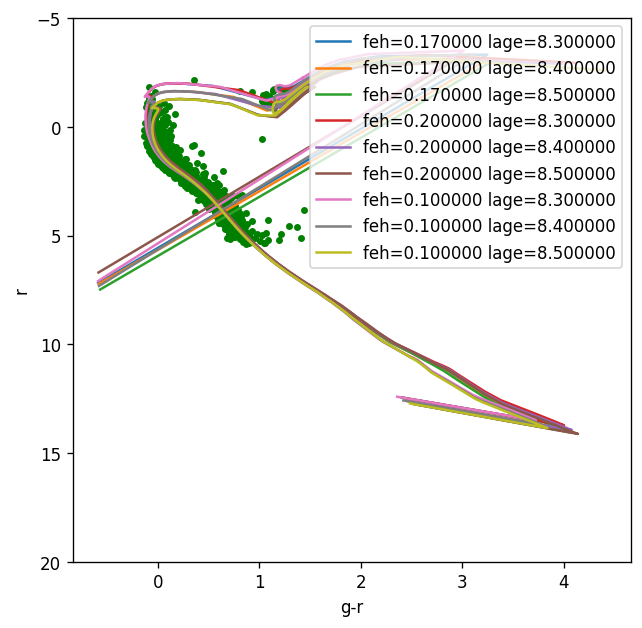

In [8]:
# Compute the isochrones
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 10000)
logagegrid = [8.3,8.4,8.5]
fehgrid = [0.17,0.2,0.1]
fig = plt.figure(figsize=(6, 6), dpi=120)
for feh in fehgrid:
    for lage in logagegrid:
        iso = ii(massgrid, lage, feh)
        plt.plot(iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'], iso['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.scatter(orig_scatter['bp_rp']-0.6,orig_scatter['mean_absolute_mag_g_band']-1.1,s=10,color='g')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(20, -5)

In [9]:
iso = ii(massgrid, 8.5, 0.17)

In [10]:
isochrone=pd.DataFrame()
isochrone['BPRP']=iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
isochrone['Gaia_G_DR2Rev']=iso['Gaia_G_EDR3']
isochrone=isochrone[isochrone['Gaia_G_DR2Rev']>10.0]

p_slopes=[]

x=isochrone['BPRP']
y=isochrone['Gaia_G_DR2Rev']
for i in range(len(isochrone)-1):    
    dy=y[i+1]-y[i]
    dx=x[i+1]-x[i]
    p_slopes.append(-1*dx/dy)
p_slopes.append(0)
isochrone['p_slopes']=p_slopes
isochrone['slopes']=-1/isochrone['p_slopes']



In [11]:
isochrone=isochrone.dropna()

# We now want to figure out a way of trimming off after the main sequence.

We know that there is a bias (look at GAIA paper) on selecting stars with bprp<1.2

In [12]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Cluster_analysis')

In [13]:
orig_scatter['phot_g_mean_mag_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_g_mean_flux_error']/orig_scatter['phot_g_mean_flux'])**2+0.0027553202**2)
orig_scatter['bp_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_bp_mean_flux_error']/orig_scatter['phot_bp_mean_flux'])**2+0.0037793818**2)
orig_scatter['rp_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_rp_mean_flux_error']/orig_scatter['phot_rp_mean_flux'])**2+0.0027901700**2)
orig_scatter['bp_rp_error']=np.sqrt(orig_scatter['rp_error']**2+orig_scatter['bp_error']**2)

In [14]:
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 10000)
logagegrid = [8.5]
fehgrid = [0.17]

In [15]:
iso=ii(massgrid, lage, feh)

In [16]:

iso['BPRP']=iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
iso['Gaia_G_DR2Rev']=iso['Gaia_G_EDR3']

In [17]:
isochrone=pd.DataFrame()
isochrone['BPRP']=iso['BPRP']
isochrone['Gaia_G_DR2Rev']=iso['Gaia_G_DR2Rev']

In [18]:
isochrone=isochrone.dropna()

In [19]:
isochrone=isochrone[isochrone['BPRP']<1.2]
isochrone=isochrone[isochrone['Gaia_G_DR2Rev']>-0.5].reset_index(drop=True)

In [20]:
x=orig_scatter['bp_rp']
y=orig_scatter['mean_absolute_mag_g_band']

In [21]:
p_slopes=[]
from sklearn.preprocessing import StandardScaler
x=isochrone['BPRP']
y=isochrone['Gaia_G_DR2Rev']
for i in range(len(isochrone)-1):    
    dy=y[i+1]-y[i]
    dx=x[i+1]-x[i]
    p_slopes.append(-1*dx/dy)
p_slopes.append(0)
isochrone['p_slopes']=p_slopes
isochrone['slopes']=-1/isochrone['p_slopes']

all_likelihood=[]

train_sccatter=orig_scatter
for j in range(11,13):
    print(j)
    orig_scatter['mean_absolute_mag_g_band']=orig_scatter['mean_absolute_mag_g_band']-0.07*j
    likelihood=[]
    for i in range(9):
        print(i)
        orig_scatter=train_sccatter
        orig_scatter['bp_rp']=orig_scatter['bp_rp']-0.1*i
        
        #this is the bound on where we define the perpendicular lines
        #------------------------------------------------------------
        high_c=[]
        low_c=[]
        for i in range(len(isochrone)-1):
            high_c.append(isochrone['Gaia_G_DR2Rev'][i+1] - isochrone['p_slopes'][i]*isochrone['BPRP'][i+1])
            low_c.append(isochrone['Gaia_G_DR2Rev'][i] - isochrone['p_slopes'][i]*isochrone['BPRP'][i])
        high_c.append(0)
        low_c.append(0)
        isochrone['low_c']=high_c #high c is low c oops
        isochrone['high_c']=low_c
        #i got them the wrong way around but the code works
        #------------------------------------------------------------
        #scaler tranformation
        scaler=StandardScaler(with_mean=False,with_std=False)

        #------------------------------------------------------------
        #should it be true or false on the mean
        #this just takes the final two values away, stops any things with zero slopes at the end.
        #------------------------------------------------------------
        isochrone=isochrone.loc()[0:len(isochrone)-2]
        
        tests=[]
        err_means=[]
        for i in range(len(isochrone)-1):
            try:
                x=(orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i]) #in correct region lowere bound
                y=(isochrone['low_c'][i]<=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i])  #in correct region upper bound
                
                #------------------------------------------------------------
                # Here we get rid of all of the points which have been selected by the algo so far and parse ones 
                test=orig_scatter[x]
                orig_scatter=orig_scatter[~x]
                orig_scatter=orig_scatter[~y]
                test=test[y]
                orig_scatter[orig_scatter]
                #------------------------------------------------------------
                #We find the random variable mean and variance which correponds to the distance from the line on the isochrone
                #------------------------------------------------------------

                #y proj is the projection onto the colour
                test['yproj']=((1/np.sqrt(1+isochrone['slopes'][i]**2))*(test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]-isochrone['Gaia_G_DR2Rev'][i] + isochrone['slopes'][i]*isochrone['BPRP'][i]))*(1/np.sqrt(1+isochrone['p_slopes'][i]**2))
                test['yproj_err']=((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)*(1/(1+isochrone['p_slopes'][i]**2))

                test['y']=((1/np.sqrt(1+isochrone['slopes'][i]**2))*(test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]-isochrone['Gaia_G_DR2Rev'][i] + isochrone['slopes'][i]*isochrone['BPRP'][i]))
                test['y_err']=((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)
                #------------------------------------------------------------                
                tests.append(test)
                err_means.append(test['y_err'].mean())
            except:
                print(i)
                continue
                
        # i should probably include this loop into the above    
        for i in range(len(isochrone)-1):
            if(len(tests[i])>1):
                
                var=1#tests[i]['y'].replace('nan',0.0).fillna(0.0).astype(float).values.var()
                tests[i]['y']=scaler.fit_transform(tests[i]['y'].replace('nan',0.0).fillna(0.0).astype(float).values.reshape(-1,1))
                tests[i]['y_err']=tests[i]['y_err'].replace('nan',0.0).fillna(0.0).astype(float)/var
            else:    
                continue
        
        #------------------------------------------------------------ 
        # Now make it into trainable format by flattening
        tests2=[tests[i]['y'] for i in range (len(isochrone)-1)]
        testserr=[tests[i]['y_err'] for i in range (len(isochrone)-1)]
        x=[tests[i]['bp_rp'] for i in range (len(isochrone)-1)]
        y=[tests[i]['mean_absolute_mag_g_band'] for i in range (len(isochrone)-1)]

        flat_test=[j for sublist in tests2 for j in sublist]
        flat_test=np.array(flat_test).reshape(len(flat_test))

        flat_testerr=[j for sublist in testserr for j in sublist]
        flat_testerr=np.array(flat_testerr).reshape(len(flat_testerr))

        flat_x=[j for sublist in x for j in sublist]
        flat_x=np.array(flat_x).reshape(len(flat_x))

        flat_y=[j for sublist in y for j in sublist]
        flat_y=np.array(flat_y).reshape(len(flat_y))
        #------------------------------------------------------------ 

        gmm_GES=XDGMM(2).fit(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
        prob_ges=gmm_GES.logL(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
        likelihood.append(prob_ges)
        orig_scatter['mean_absolute_mag_g_band']=y
        orig_scatter['bp_rp']=x
    all_likelihood.append(np.array(likelihood))    

11
0


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_20813/4076117573.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  orig_scatter=orig_scatter[~y]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required.

In [ ]:
likelihood

[797.7875641958918,
 863.4185509179255,
 900.9313720025921,
 932.7425132077958,
 938.0364856382188,
 934.083843418341,
 930.9656338367981,
 904.8571444215095,
 884.5616429791626,
 887.2764085820776,
 901.4038481517579,
 919.4517082493999,
 919.0547974961994,
 901.6213947321802,
 893.469401110523,
 881.1510782585456,
 906.029481795061,
 887.4110446292336,
 955.8535324707116,
 944.0469225472928,
 923.6270871170576,
 930.6328821616885,
 933.7752529108444,
 956.2171540723094,
 943.4874434308732,
 942.6498306656217,
 944.7337307638678,
 1003.4668912928819,
 982.0150620313368,
 991.6082781218878,
 973.2935779114891,
 986.1837298802805,
 990.1293875950237,
 913.7376291308876,
 957.728721761338,
 975.559594319207,
 990.5722280306065,
 988.6856298495852,
 997.4358488599692,
 973.1729680821236,
 1043.5149932683303,
 1067.9816970655465,
 988.3261469971192,
 966.458674792319,
 1006.7937375052693,
 918.1689757521742,
 946.1167089990665,
 986.7637354148079,
 1007.9959230400443,
 954.8814590510165,
 

(10.0, -5.0)

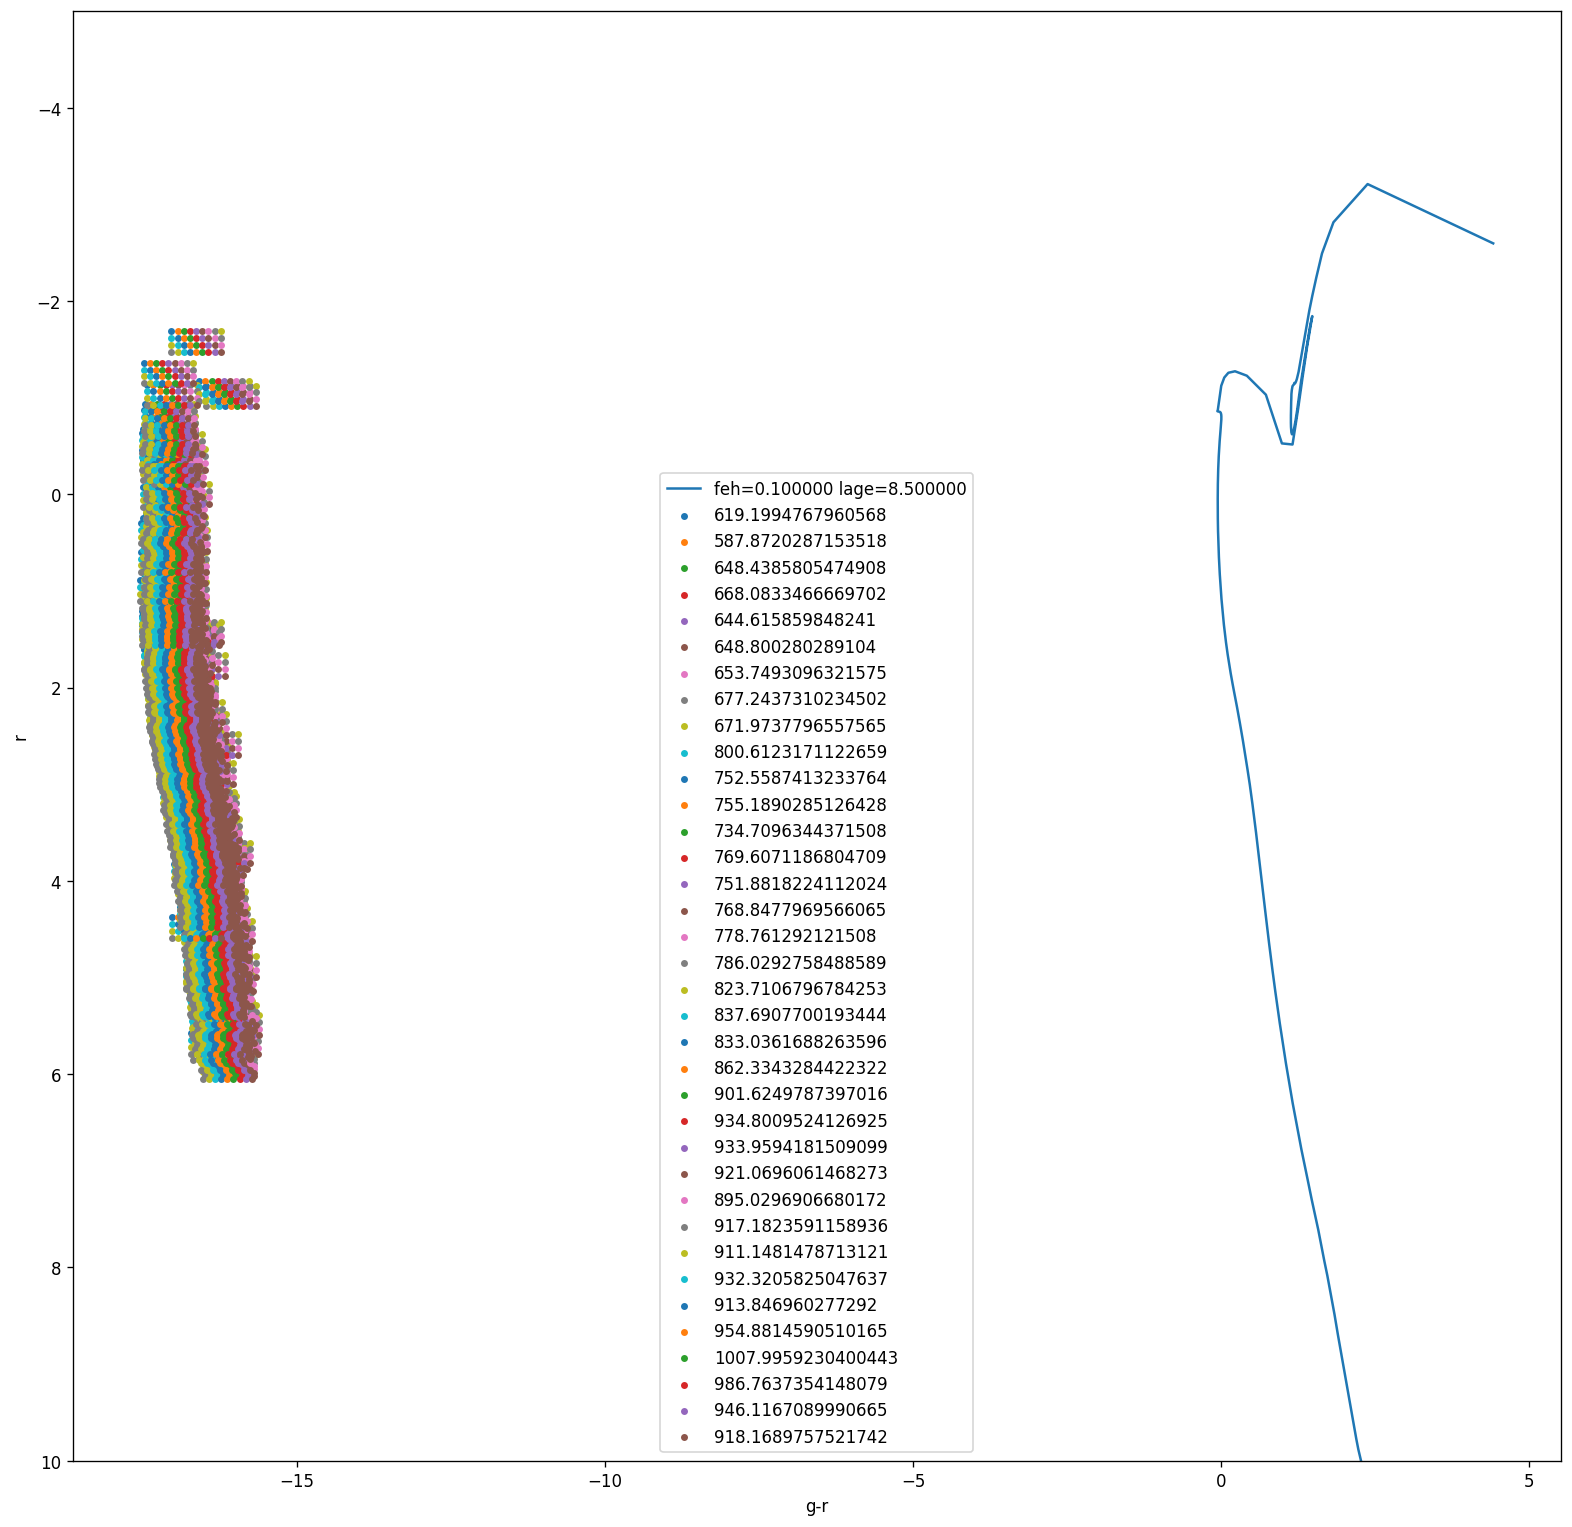

In [ ]:
massgrid = 10**np.linspace(np.log10(0.1),np.log10(10), 10000)
logagegrid = [8.3,8.4,8.5]
fehgrid = [0.17,0.2,0.1]
fig = plt.figure(figsize=(16, 16), dpi=120)
plt.plot(iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3'], iso['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
for j in range(11,15):
    for i in range(9):
        plt.scatter(orig_scatter['bp_rp']+0.1*i,orig_scatter['mean_absolute_mag_g_band']+0.07*j,s=10,label=likelihood[len(likelihood)-1-i-j*9])
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(10, -5)